# EDA 목표
### 식별자 id 변수와 종속변수 loss를 제외한 총 변수는 130개<br>
=> 변수가 너무 많으므로 PCA를 이용해서 모델링을 해보자.

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import os

In [2]:
# os.chdir(r"C:\Users\ByungjooCho\Google 드라이브\스터디 프로젝트\allstate-claims-severity")
os.chdir(r"C:\Users\Master\Google 드라이브\스터디 프로젝트\allstate-claims-severity")

In [3]:
df = pd.read_csv('train.csv', header='infer', encoding='latin1')

In [4]:
df.shape

(188318, 132)

###### 데이터 전체 결측치 확인

In [5]:
df.isnull().sum().sum()

0

In [8]:
X = df.drop(columns=["loss"])
Y = df.loss
header = df.columns
Y.columns=["loss"]

### 변수 변환¶
다음과 같은 경우에는 로그 함수 혹은 제곱근 함수 등을 사용하여 변환된 변수를 사용하면 회귀 성능이 향상될 수도 있다.<br>

독립 변수나 종속 변수가 심하게 한쪽으로 치우친 분포를 보이는 경우<br>
독립 변수와 종속 변수간의 관계가 곱셈 혹은 나눗셉으로 연결된 경우<br>
종속 변수와 예측치가 비선형 관계를 보이는 경우<br>
원래 선형회귀모형의 가정에는 독립 변수나 종속 변수가 반드시 대칭 분포를 보여야 한다는 가정은 없지만<br> 
정규 분포에 가까운 분포를 보일 수록 선형회귀모형의 성능이 좋아지는 경우가 많다.<br>

출처 :  https://datascienceschool.net/view-notebook/afb99de8cc0d407ba32079590b25180d/

In [9]:
loss_log = np.log(df.loss)

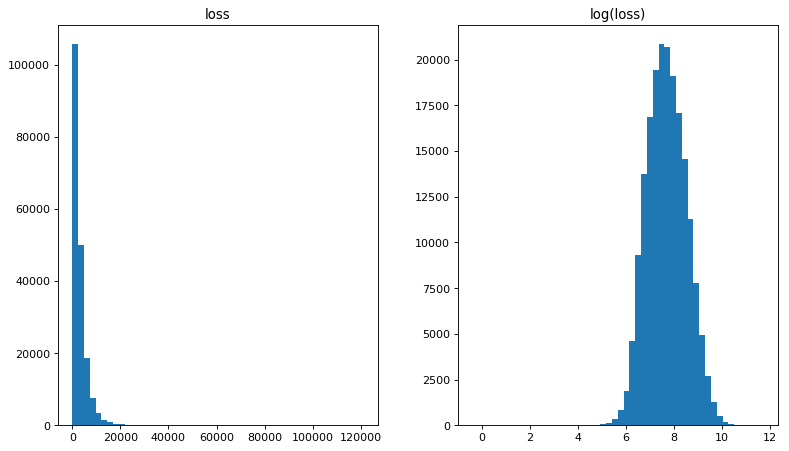

In [10]:
fig0=plt.figure(figsize=(10,5), dpi=80)       
axes1 = fig0.add_axes([0,0,0.4,1])            
axes2 = fig0.add_axes([0.5,0,0.4,1])          
axes1.hist(df.loss, bins =50)  
axes2.hist(loss_log, bins=50)
axes1.set_title('loss')
axes2.set_title('log(loss)')
plt.show()

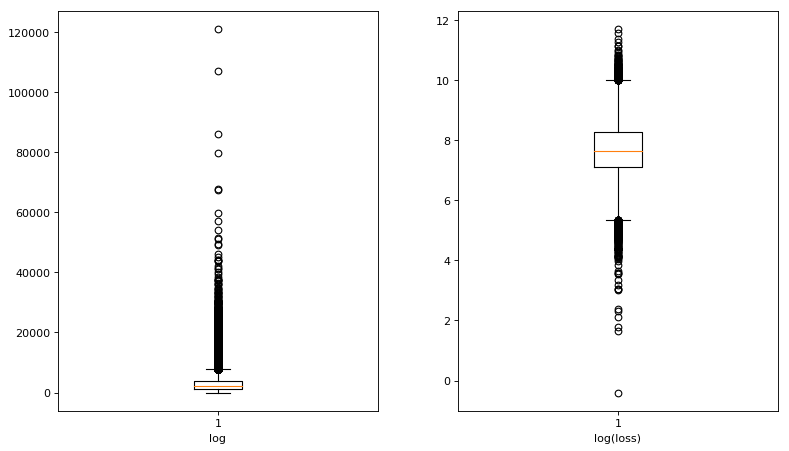

In [11]:
fig0=plt.figure(figsize=(10,5), dpi=80)       
axes1 = fig0.add_axes([0,0,0.4,1])            
axes2 = fig0.add_axes([0.5,0,0.4,1])          
axes1.boxplot(df.loss)  
axes2.boxplot(loss_log)
axes1.set_xlabel('log')
axes2.set_xlabel('log(loss)')

plt.show()

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=3)

In [13]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(131822, 131)
(56496, 131)
(131822,)
(56496,)


### id 변수는 추후에 모델을 학습할 때는 제외해야하므로 일단 제외.

In [14]:
X_train_id = X_train["id"]
X_train= X_train.drop(columns=["id"])
Y_train= Y_train.drop(columns=["id"])

In [15]:
X_test_id = X_test["id"]
X_test= X_test.drop(columns=["id"])
Y_test= Y_test.drop(columns=["id"])

In [16]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(131822, 130)
(56496, 130)
(131822,)
(56496,)


In [327]:
pd.Series.unique(X_train.iloc[0:,0]) 

array(['A', 'B'], dtype=object)

### cat1 ~ cat116 카테고리의 등급 알아보기
PCA를 사용하기 위해서는 명목형 변수가 있어서는 안됨<br>
그래서 등급에 따라서 점수를 부여하려고 했으나, 데이터 구조상 그럴 수가 없음<br>
=> 더미변수의 필요성

In [181]:
#for i in range(0,116):
#    print(pd.Series.unique(X_train.iloc[0:,i]))

In [182]:
#for i in range(0,116):
#    print(pd.Series.value_counts(X_train.iloc[0:,i]))

In [328]:
X_train.iloc[:,115].values

array(['DJ', 'HA', 'DJ', ..., 'DP', 'CK', 'HL'], dtype=object)

In [329]:
X_train_le=X_train
X_train_le[X_train.columns[0:116]].values

array([['A', 'A', 'A', ..., 'C', 'L', 'DJ'],
       ['A', 'B', 'A', ..., 'A', 'K', 'HA'],
       ['A', 'B', 'A', ..., 'A', 'K', 'DJ'],
       ...,
       ['A', 'B', 'A', ..., 'A', 'P', 'DP'],
       ['B', 'B', 'A', ..., 'A', 'M', 'CK'],
       ['A', 'A', 'A', ..., 'F', 'O', 'HL']], dtype=object)

In [330]:
df1=pd.DataFrame(X_train.iloc[:,0:116])

In [331]:
X=df1['cat1'].values
cat_le =LabelEncoder()
X=cat_le.fit_transform(X)
print(X)

[0 0 0 ... 0 1 0]


In [332]:
X=df1['cat116'].values
cat_le =LabelEncoder()
X=cat_le.fit_transform(X)
print(X)

[ 76 164  76 ...  82  52 175]


### 각 cat변수들의 값 종류

In [333]:
print(pd.unique(X_train['cat116']))
print(len(X_train['cat116'].unique()))

['DJ' 'HA' 'GC' 'DP' 'KR' 'CR' 'IH' 'LI' 'HK' 'CK' 'CB' 'IN' 'IE' 'EC'
 'HG' 'HX' 'GS' 'LO' 'HC' 'HH' 'DC' 'LN' 'HQ' 'EK' 'IT' 'CD' 'LF' 'CM'
 'CP' 'KC' 'LB' 'HN' 'HV' 'MD' 'IF' 'DF' 'GX' 'HB' 'GE' 'LM' 'KW' 'LL'
 'HJ' 'CU' 'CO' 'JX' 'FH' 'GK' 'IQ' 'CN' 'LJ' 'GB' 'BV' 'HL' 'GI' 'EO'
 'HW' 'FC' 'IC' 'FD' 'CT' 'K' 'EI' 'CS' 'ME' 'FR' 'KL' 'EG' 'IG' 'MG' 'DI'
 'E' 'EA' 'CW' 'GP' 'KJ' 'LW' 'CQ' 'BQ' 'JR' 'FE' 'BY' 'GT' 'DK' 'BP' 'HR'
 'GA' 'LV' 'FG' 'DS' 'CH' 'CI' 'EY' 'KA' 'KT' 'HM' 'KN' 'MJ' 'DH' 'FT'
 'JW' 'BD' 'LY' 'EE' 'HE' 'EP' 'KY' 'CC' 'HP' 'GU' 'GO' 'KD' 'MC' 'HI'
 'GN' 'FB' 'CG' 'BX' 'KX' 'LQ' 'GJ' 'LX' 'DD' 'DN' 'LC' 'MP' 'U' 'KP' 'HF'
 'FX' 'FV' 'IR' 'KB' 'MI' 'EH' 'DT' 'DL' 'GW' 'JP' 'GM' 'LD' 'EB' 'AX'
 'DU' 'EL' 'KI' 'MO' 'IY' 'MR' 'LH' 'KQ' 'GL' 'JL' 'FO' 'GF' 'IU' 'AJ'
 'JU' 'DA' 'MU' 'LE' 'ED' 'ID' 'KU' 'FA' 'MK' 'HY' 'EF' 'DX' 'MA' 'CA' 'H'
 'AC' 'LA' 'CL' 'AF' 'ES' 'BO' 'I' 'JM' 'AO' 'EJ' 'GV' 'FF' 'EN' 'AD' 'BF'
 'L' 'JE' 'IP' 'CF' 'FW' 'LU' 'MQ' 'CX' 'JF' 'KE' 'IL' 'I

#### 각 cat변수들 Label-Encoding

In [334]:
a=[]
for i in df1.columns:
    X=df1[i].values
    cat_le =LabelEncoder()
    X=cat_le.fit_transform(X)   
    a=a+[X]
b=np.array(a)

In [335]:
b.shape

(116, 131822)

#### DataFrame으로 만들기 위해서 전치행렬로 바꿔준다.

In [336]:
b=b.T
X_train_cat = pd.DataFrame(b)

In [337]:
X_train_cat

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,114,115
0,0,0,0,0,0,1,0,0,0,0,...,6,1,31,43,0,30,0,2,11,76
1,0,1,0,0,1,0,0,0,1,0,...,5,1,31,104,0,46,48,0,10,164
2,0,1,0,0,1,0,0,0,1,0,...,5,1,31,58,0,15,48,0,10,76
3,0,1,0,0,0,0,0,0,1,1,...,12,10,31,9,0,31,60,0,16,140
4,0,1,0,0,1,0,0,0,1,0,...,5,1,31,100,0,0,23,0,10,82
5,0,0,0,1,0,0,0,0,0,0,...,5,3,31,13,4,6,45,0,10,250
6,0,1,0,0,1,1,0,0,1,0,...,7,1,31,3,0,8,39,2,11,59
7,0,1,0,0,1,0,0,0,1,1,...,10,10,31,49,0,24,49,0,16,196
8,0,1,0,0,0,0,0,0,1,0,...,10,4,31,43,0,30,12,0,14,266
9,1,0,0,0,1,1,0,0,0,0,...,5,1,2,104,0,14,48,7,10,174


limit_output extension: Maximum message size of 10000 exceeded with 25493 characters

####  cat변수이름 원래대로

In [338]:
a=[]
for i in range(1,117) :
    b= 'cat'+ str(i)   
    a+=[b]
X_train_cat.columns=a
# X_train_cat

### cont변수 부분 확인

In [339]:
X_train.columns[116:130]

Index(['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8',
       'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14'],
      dtype='object')

In [340]:
X_train_cont=X_train[X_train.columns[116:130]].values
print(X_train_cont.shape)
X_train_cont=pd.DataFrame(X_train_cont)
# X_train_cont

(131822, 14)


In [341]:
X_train_cont.columns=df.columns[117:131]
# X_train_cont

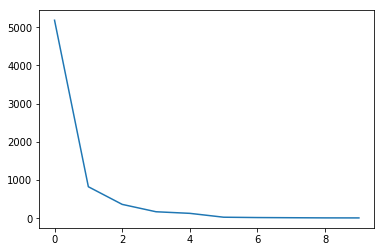

In [342]:
model=PCA(n_components=10)
results = model.fit(X_train_cat)
Z = results.transform(X_train_cat)
plt.plot(results.explained_variance_)
plt.show()

In [343]:
pca = pd.DataFrame(Z)
#pca

In [344]:
X_train_cat=pca.iloc[:,0:2]

In [345]:
X_train = pd.concat([X_train_cat, X_train_cont], axis = 1)
X_train

,0,1,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,-71.952397,32.600510,0.393339,0.555782,0.819748,0.259793,0.397069,0.374877,0.560801,0.31796,0.35897,0.32935,0.472726,0.462286,0.321548,0.812096
1,16.773498,-33.325531,0.493164,0.100099,0.201309,0.821574,0.811271,0.329836,0.259679,0.39455,0.39648,0.32935,0.275431,0.301921,0.295948,0.297212
2,-69.327437,15.601634,0.513457,0.785784,0.549770,0.594598,0.811271,0.421047,0.412356,0.62918,0.50630,0.37493,0.338312,0.331643,0.315758,0.189748
3,-2.720204,61.803332,0.261841,0.299102,0.484196,0.463029,0.534484,0.320802,0.366400,0.81542,0.32128,0.36458,0.457203,0.447145,0.695650,0.740509
4,-66.584598,-25.421576,0.484469,0.620805,0.549770,0.452887,0.499798,0.332963,0.377235,0.58354,0.44352,0.39599,0.341813,0.352251,0.339244,0.399007
5,105.573996,54.947656,0.496063,0.422197,0.654310,0.318422,0.281143,0.510054,0.951754,0.63475,0.53565,0.50556,0.859322,0.848992,0.342239,0.230365
6,-85.004903,71.464632,0.254071,0.422197,0.298977,0.336414,0.482436,0.288198,0.330458,0.29260,0.24958,0.27777,0.180456,0.178698,0.304350,0.252605
7,51.021692,20.509496,0.367378,0.061000,0.139862,0.493605,0.288217,0.593046,0.425740,0.67263,0.39648,0.25604,0.415029,0.443374,0.633362,0.333068
8,118.478061,25.795074,0.458463,0.785784,0.654310,0.259793,0.397069,0.890740,0.966972,0.29260,0.41675,0.68520,0.927095,0.920142,0.731059,0.807032
9,26.201157,-33.955485,0.634734,0.620805,0.397983,0.869299,0.845727,0.456654,0.423280,0.36083,0.46853,0.51666,0.527274,0.515644,0.363547,0.258764


limit_output extension: Maximum message size of 10000 exceeded with 26454 characters

### test 데이터도 전처리해주기

In [346]:
X_test.shape

(56496, 130)

In [347]:
df2=pd.DataFrame(X_test.iloc[:,0:116])
df2.shape

(56496, 116)

In [353]:
a=[]
for i in df2.columns:
    X=df2[i].values
    cat_le =LabelEncoder()
    X=cat_le.fit_transform(X)   
    a=a+[X]
b=np.array(a)

In [354]:
b=b.T
X_test_cat = pd.DataFrame(b)
X_test_cat

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,114,115
0,0,1,0,1,0,0,0,0,1,1,...,3,1,28,90,2,8,42,0,6,156
1,1,0,0,0,0,1,0,0,0,0,...,11,4,28,50,0,1,12,3,14,214
2,0,1,0,0,0,0,0,0,1,0,...,6,1,2,40,0,35,32,0,8,41
3,0,1,0,0,0,0,0,0,1,0,...,10,10,28,57,0,23,3,0,11,146
4,1,0,0,0,1,0,0,0,0,0,...,6,1,28,90,0,35,33,0,8,79
5,0,0,0,1,0,0,0,0,0,0,...,6,1,28,3,4,8,33,0,9,77
6,1,0,0,0,0,1,0,0,0,0,...,5,1,55,53,0,22,20,3,8,69
7,0,0,0,1,1,0,0,0,0,0,...,5,7,2,53,7,50,51,0,6,161
8,1,0,0,1,0,0,0,0,0,0,...,6,7,28,86,2,46,3,0,5,47
9,0,0,0,0,0,1,0,0,0,0,...,9,10,28,56,0,28,8,3,13,154


limit_output extension: Maximum message size of 10000 exceeded with 25443 characters

In [360]:
a=[]
for i in range(1,117) :
    b= 'cat'+ str(i)   
    a+=[b]
X_test_cat.columns=a

In [361]:
X_test.columns[116:130]
X_test_cont=X_test[X_test.columns[116:130]].values
print(X_test_cont.shape)
X_test_cont=pd.DataFrame(X_test_cont)
X_test_cont.columns=df.columns[117:131]


(56496, 14)


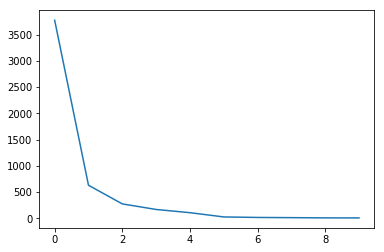

In [362]:
model=PCA(n_components=10)
results = model.fit(X_test_cat)
Z = results.transform(X_test_cat)
plt.plot(results.explained_variance_)
plt.show()

In [363]:
pca = pd.DataFrame(Z)
pca

,0,1,2,3,4,5,6,7,8,9
0,32.818899,-29.833594,-10.379045,-16.377269,3.563883,7.842461,7.309370,3.432312,-1.900005,-2.472837
1,90.118097,10.025709,20.918666,-22.902781,-4.041598,-2.137373,-2.449288,-1.171458,5.579998,-1.912741
2,-81.287449,23.343702,-16.405388,11.507405,-20.393928,0.875096,1.362893,-3.187541,-0.551706,-1.500391
3,21.616537,5.383208,25.123581,-0.592225,-3.363656,-6.007082,0.025421,2.927665,5.288548,1.632211
4,-44.439269,-27.206043,-7.190273,10.985037,4.619804,2.743864,-3.791617,1.876301,1.092823,-1.347284
5,-43.694679,59.829935,-11.576695,-15.525309,3.719585,2.294753,-2.077308,-0.741570,-2.019282,-1.649176
6,-53.636506,11.276298,8.134763,-1.604291,28.590048,3.201235,-5.792694,4.306016,-3.249433,-1.511330
7,39.380167,5.731012,-26.433370,25.675843,-20.567082,6.491465,-2.639044,0.569232,-3.258537,9.401540
8,-78.256505,-20.752013,19.603682,22.703635,-0.123862,3.720573,-2.018195,-1.322833,-1.802220,9.906627
9,30.009319,5.851986,20.667513,4.345416,-2.610557,-6.518540,-0.319960,-4.725292,-0.894552,1.018768


limit_output extension: Maximum message size of 10000 exceeded with 18016 characters

In [364]:
X_test_cat=pca.iloc[:,0:2]

In [365]:
X_test = pd.concat([X_test_cat, X_test_cont], axis = 1)

### 선형회귀 모델 만들기

In [366]:
lm = LinearRegression()

In [401]:
lm.fit(X_train, Y_train)
Y_pred_test = lm.predict(X_test)

####  MSE, RMSE

In [396]:
print('MSE : ' + str(metrics.mean_squared_error(Y_test, Y_pred_test)))
print('RMSE : ' + str(np.sqrt(metrics.mean_squared_error(Y_test, Y_pred_test))))

MSE : 8253722.521045319
RMSE : 2872.929257925666


#### 잔차

In [397]:
Y_train.size

131822

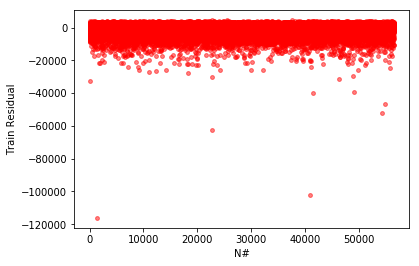

In [398]:
plt.scatter(np.arange(Y_test.size),Y_pred_test-Y_test,c = 'red', s=15, alpha=0.5)
plt.xlabel('N#')
plt.ylabel('Train Residual')
plt.show()

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


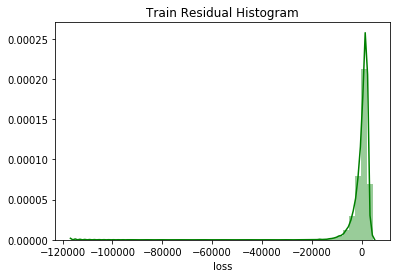

In [399]:
sns.distplot((Y_pred_test-Y_test), bins=50, color='green').set_title("Train Residual Histogram")
plt.show()

#### 결정계수

In [1]:
lm.score(X_train, Y_train)

NameError: name 'lm' is not defined

71948       371.85
131806     1470.65
171409     9580.02
49147      5456.96
104564     2236.86
16838       976.89
133390     2817.27
171295     2086.94
58278      1302.61
185873     2494.16
60719      7449.58
137726      580.89
101610    16361.80
79017      2009.84
51945      2403.46
91191       846.76
151499    10463.85
140601     8214.27
53140      1411.76
9906       1065.61
159681     2425.88
84954      1885.13
55663      4559.44
87976      3540.38
68280      2631.95
118002     1392.49
178763     2426.28
167666     4587.36
162197      609.30
97155       550.08
            ...   
97432      2111.14
108138     2198.87
72093      7581.71
161377     3824.60
4718       4178.50
72552       583.83
155205     1140.85
66394     12494.04
69555       902.88
78465      3009.20
139199     7907.17
182530     9176.42
90946      2247.46
99802      1189.31
3610        759.82
151032     1268.24
128940     7431.88
59872      1512.84
62583      2516.26
105365     1840.44
122506     5008.01
181929     9

### cat를 각 요인별 loss 평균으로 집어넣기.

In [12]:
df = df.drop(columns=["id"])
df

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,A,B,A,B,A,A,A,A,B,A,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,A,B,A,A,A,A,A,A,B,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,A,B,A,A,B,A,A,A,B,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,B,B,A,B,A,A,A,A,B,A,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,A,B,A,B,A,A,A,A,B,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85
5,A,B,A,A,A,A,A,A,B,A,...,0.364464,0.401162,0.26847,0.46226,0.50556,0.366788,0.359249,0.345247,0.726792,5142.87
6,A,A,A,A,B,A,A,A,A,A,...,0.381515,0.363768,0.24564,0.40455,0.47225,0.334828,0.352251,0.342239,0.382931,1132.22
7,A,B,A,B,A,A,A,A,B,A,...,0.867021,0.583389,0.90267,0.84847,0.80218,0.644013,0.785706,0.859764,0.242416,3585.75
8,A,B,B,B,B,A,A,A,B,B,...,0.628534,0.384099,0.61229,0.38249,0.51111,0.682315,0.669033,0.756454,0.361191,10280.20
9,A,B,A,A,B,B,A,A,B,A,...,0.713343,0.469223,0.30260,0.67135,0.83510,0.863052,0.879347,0.822493,0.294523,6184.59


In [34]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=3)

In [14]:
print(df.shape)
print(df_train.shape)
print(df_test.shape)

(188318, 131)
(131822, 131)
(56496, 131)


In [15]:
x=list(range(0,116))+list(range(130,131))

In [16]:
df_train_cat=df_train.iloc[:,x]

In [17]:
df_train_cat.groupby(['cat1'],as_index=False).mean()

,cat1,loss
0,A,3408.187283
1,B,1915.747865


In [18]:
for i in df_train_cat.columns[0:116] :
    b=df_train_cat.groupby([i],as_index=False).mean()
    print(b)

  cat1         loss
0    A  3408.187283
1    B  1915.747865
  cat2         loss
0    A  2448.612882
1    B  3810.749356
  cat3         loss
0    A  2901.217319
1    B  5378.387101
  cat4         loss
0    A  2823.583556
1    B  3495.517831
  cat5         loss
0    A  2816.758453
1    B  3463.961776
  cat6         loss
0    A  3264.153893
1    B  2513.146590
  cat7         loss
0    A  2910.097949
1    B  8243.452632
  cat8         loss
0    A  2976.887246
1    B  4017.241557
  cat9         loss
0    A  2506.493920
1    B  3839.115917
  cat10         loss
0     A  2691.604500
1     B  5008.901604
  cat11         loss
0     A  2808.919114
1     B  4943.238458
  cat12         loss
0     A  2655.462198
1     B  5192.736775
  cat13         loss
0     A  2816.666953
1     B  4947.780927
  cat14         loss
0     A  3005.352973
1     B  5674.124649
  cat15         loss
0     A  3037.611403
1     B  3425.873889
  cat16         loss
0     A  2932.379938
1     B  5998.165450
  cat17         los

  cat102          loss
0      A   2976.887246
1      B   4012.829154
2      C   3908.566067
3      D   4620.723922
4      E   4379.100396
5      F   5676.628571
6      G   7692.223846
7      H  18646.370000
8      J  17435.360000
   cat103         loss
0       A  2816.758453
1       B  3078.545931
2       C  3475.267794
3       D  4005.528191
4       E  4353.453305
5       F  4963.999618
6       G  5660.479945
7       H  5853.382109
8       I  7170.643521
9       J  7415.406364
10      K  7611.368571
11      L  7668.050000
12      N  2836.435000
   cat104         loss
0       A  3289.995652
1       B  3611.905667
2       C  2828.261458
3       D  2972.928248
4       E  2993.331634
5       F  3046.866128
6       G  3118.764561
7       H  2776.805599
8       I  2979.467014
9       J  3354.582554
10      K  3192.056494
11      L  3719.713157
12      M  3992.164241
13      N  4015.208131
14      O  3054.937647
15      P  3010.025574
16      Q  2733.520000
   cat105          loss
0       A 

   cat114         loss
0       A  3264.153893
1       B  1649.390000
2       C  2077.841695
3       D  2299.226667
4       E  2082.659032
5       F  2574.726398
6       I  3557.921973
7       J  2717.585418
8       L  4840.878364
9       N  3620.207909
10      O  5767.514765
11      Q  7945.801724
12      R  5515.113636
13      S  8164.750000
14      U  6239.696120
15      V  8998.991786
16      X  8014.220000
   cat115          loss
0       A   3112.365345
1       B   2524.740000
2       C    542.810000
3       D  17578.390000
4       E  11076.785000
5       F   5493.287917
6       G   4176.781000
7       H   3400.434804
8       I   2975.563150
9       J   3147.449186
10      K   3021.683888
11      L   3053.997192
12      M   2959.590455
13      N   3014.763676
14      O   2948.140003
15      P   3030.505101
16      Q   3076.133932
17      R   2911.400535
18      S   2982.035318
19      T   3627.835000
20      U   3355.030556
21      W   2022.870000
22      X   3637.763333
    cat116

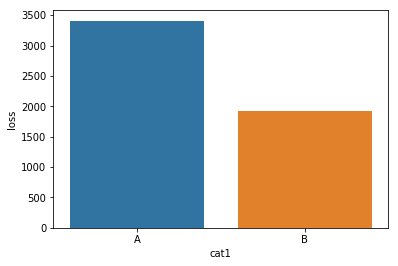

In [27]:
sns.barplot(x='cat1',y='loss',data=df_train_cat.groupby(['cat1'],as_index=False).mean())
plt.show()

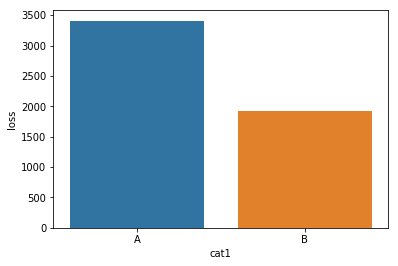

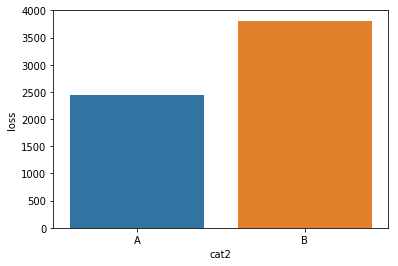

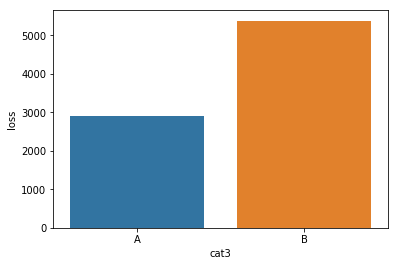

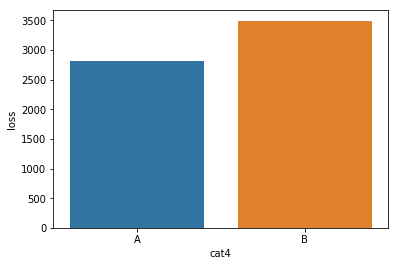

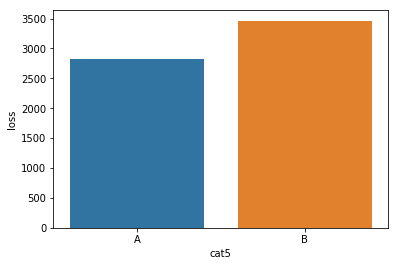

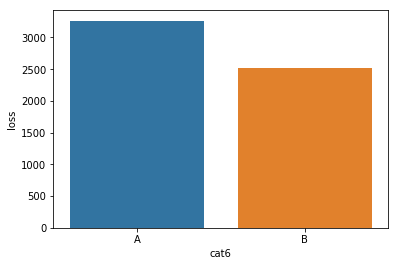

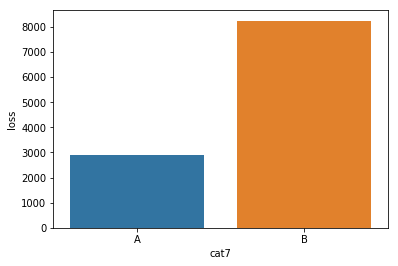

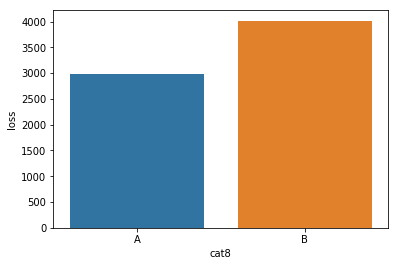

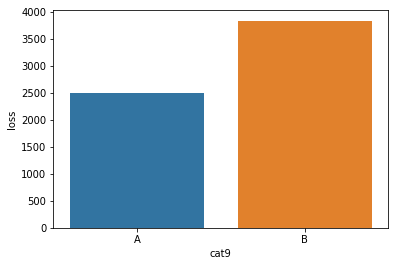

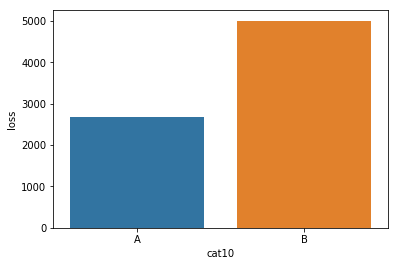

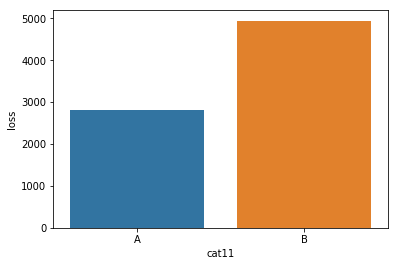

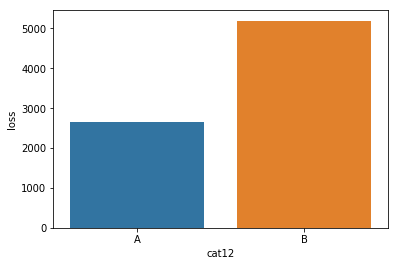

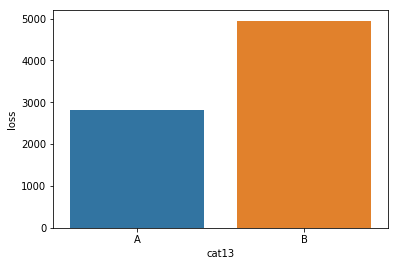

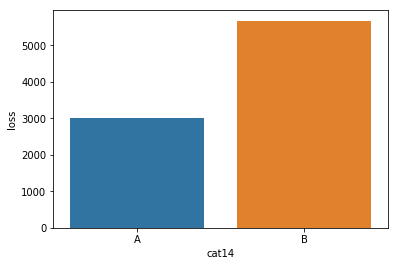

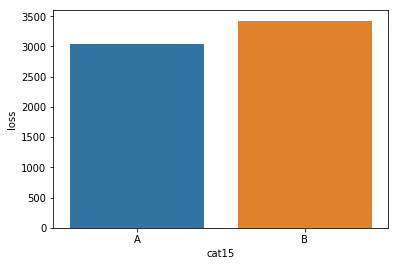

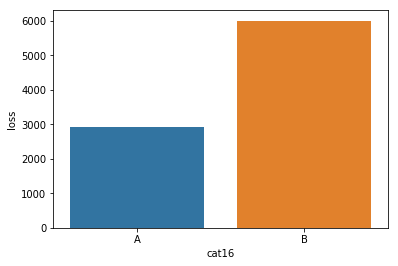

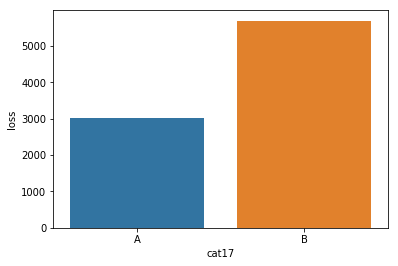

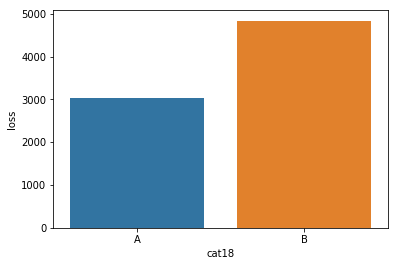

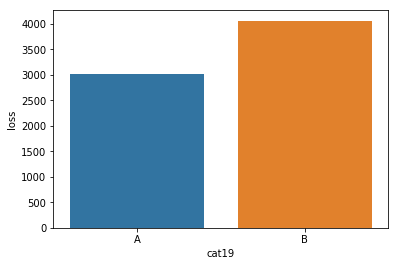

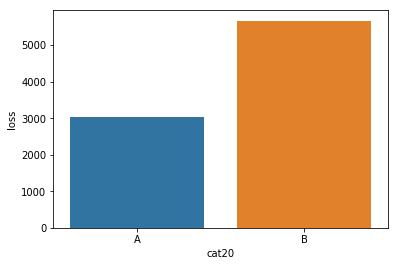

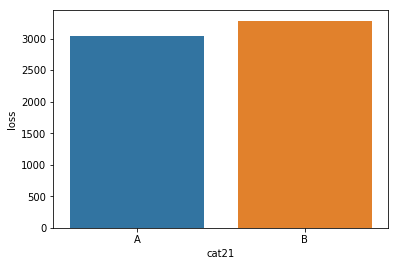

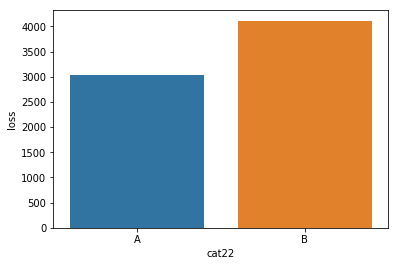

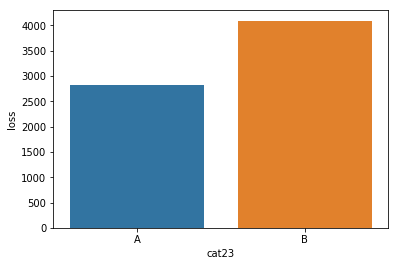

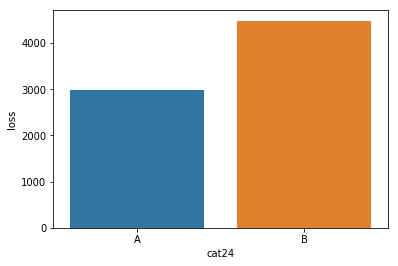

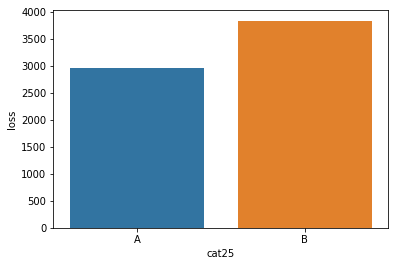

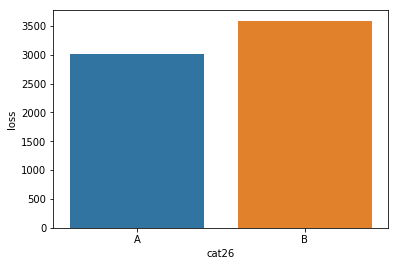

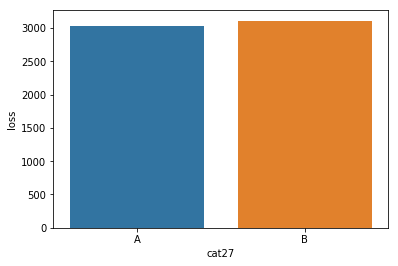

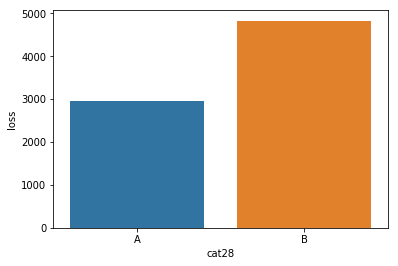

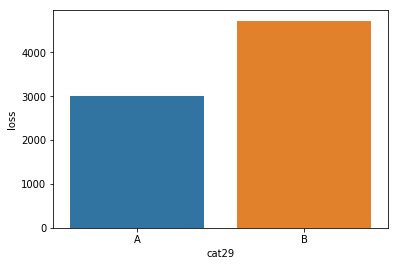

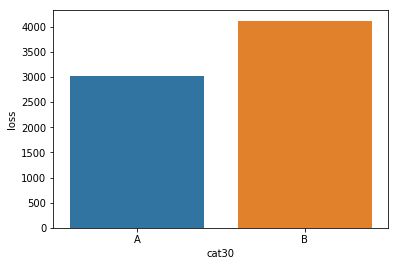

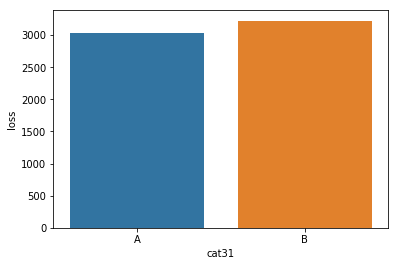

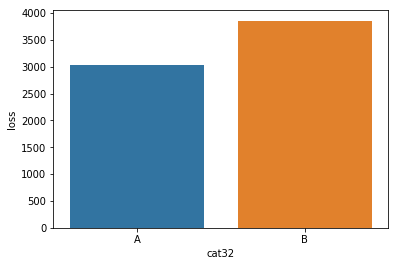

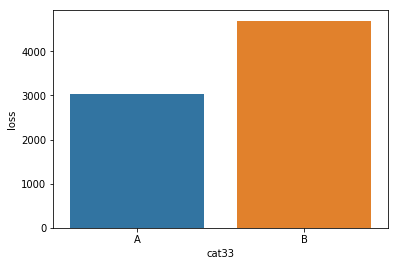

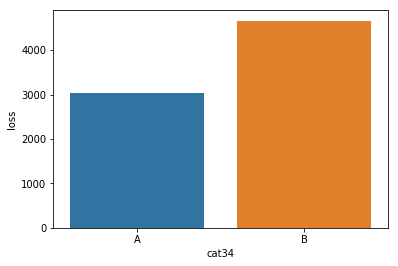

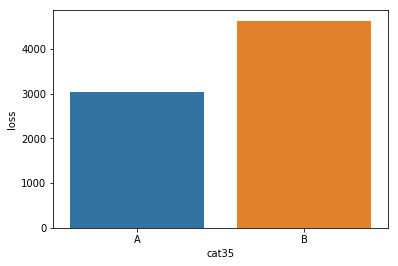

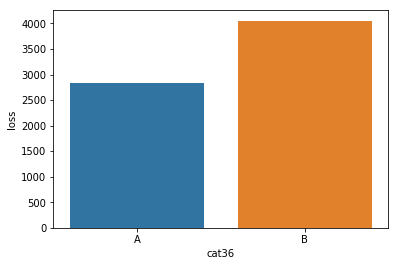

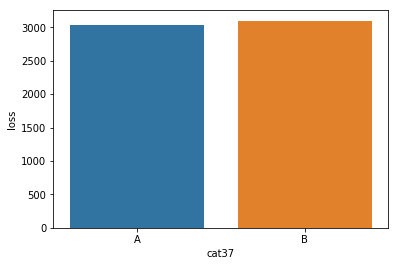

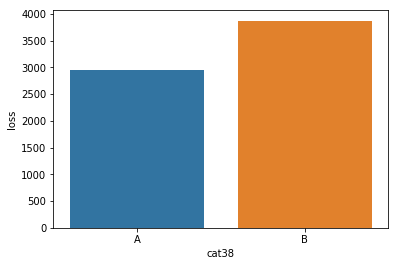

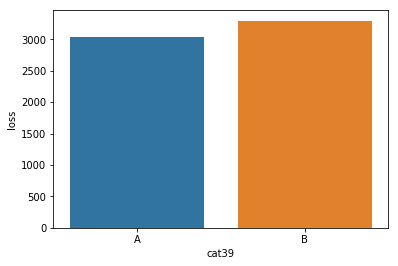

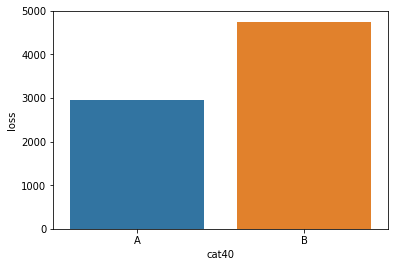

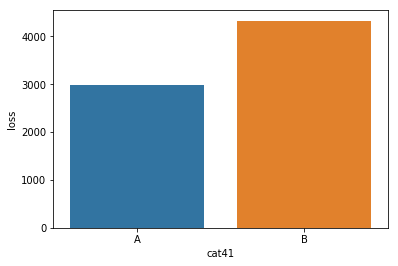

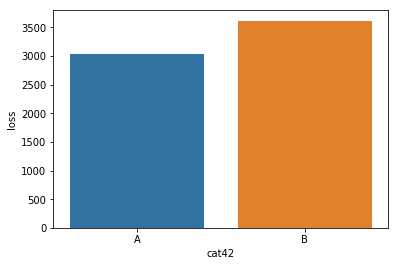

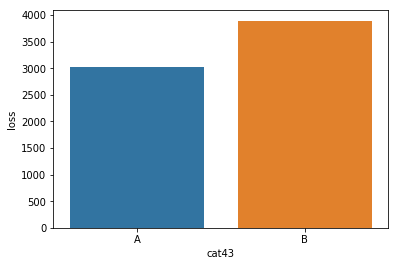

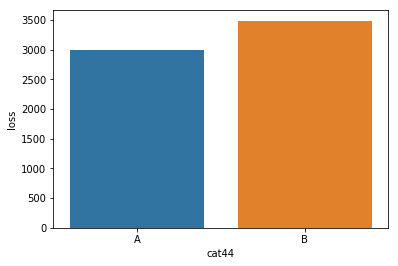

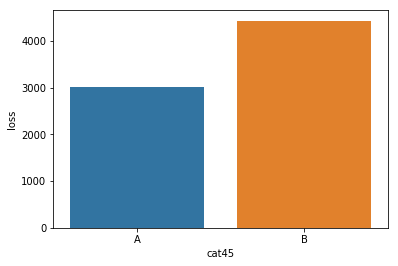

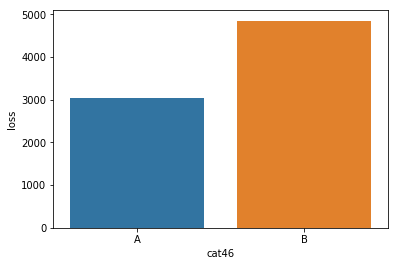

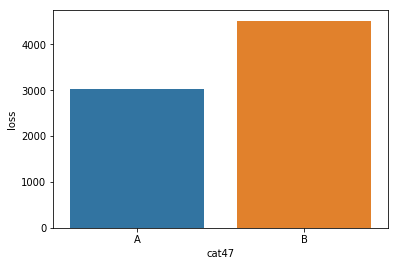

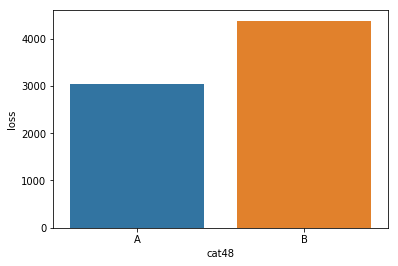

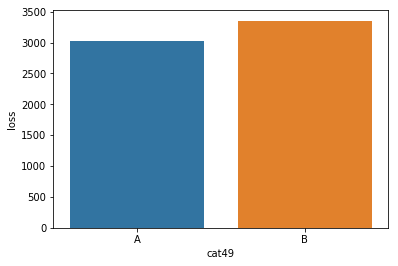

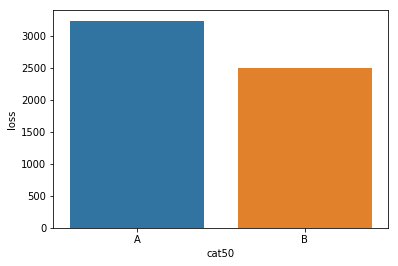

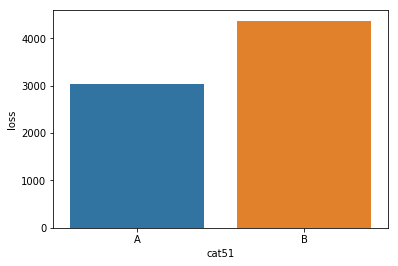

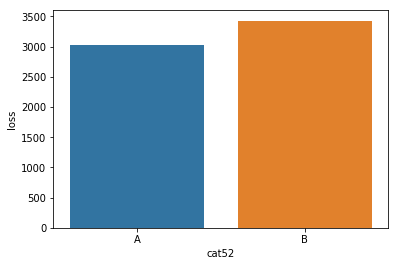

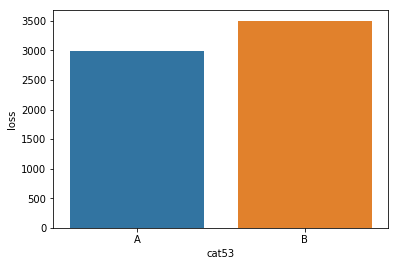

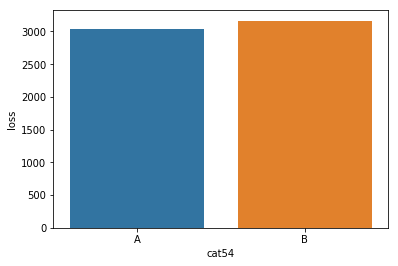

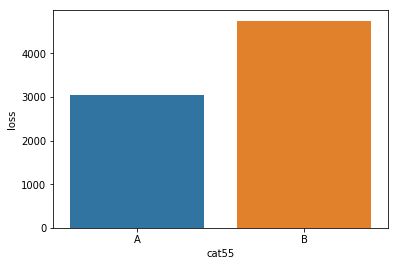

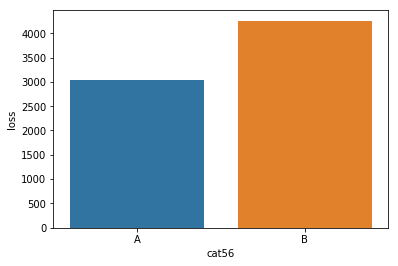

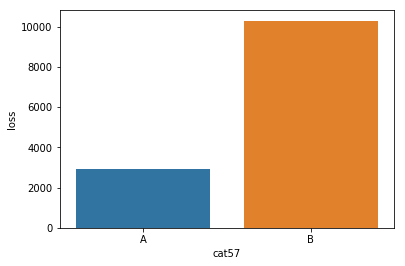

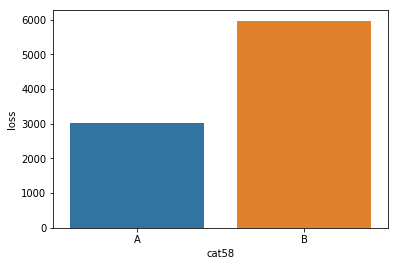

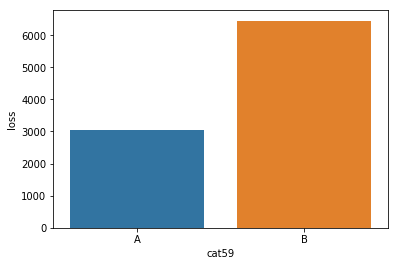

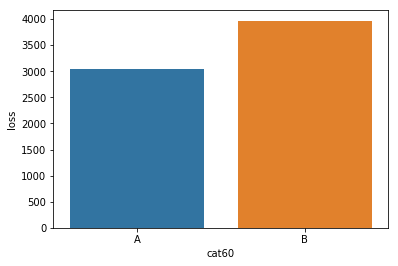

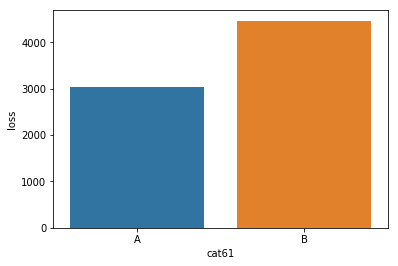

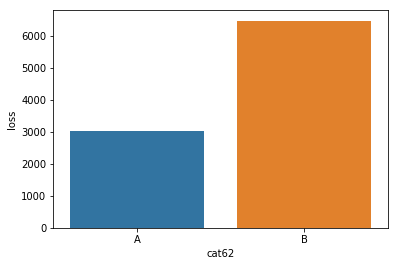

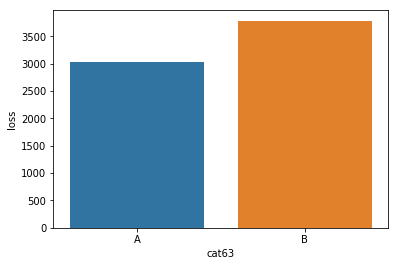

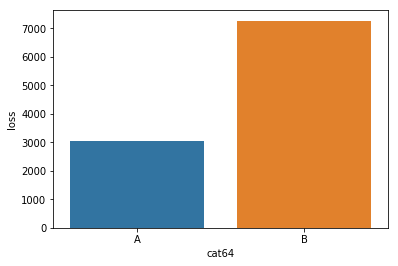

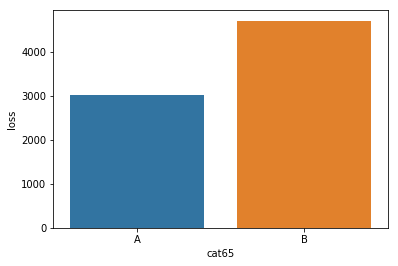

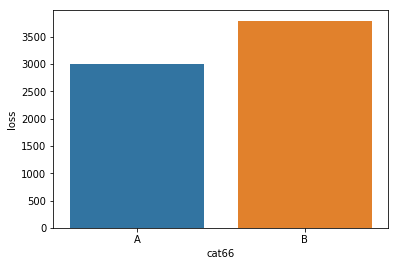

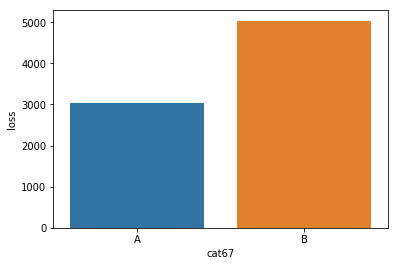

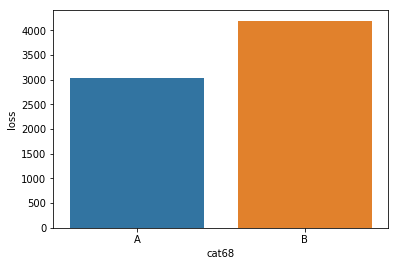

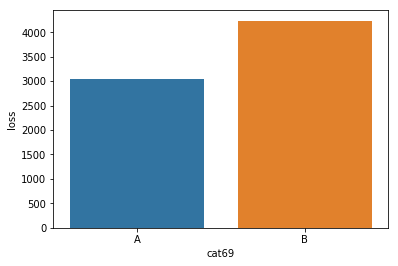

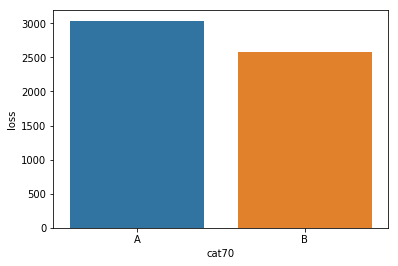

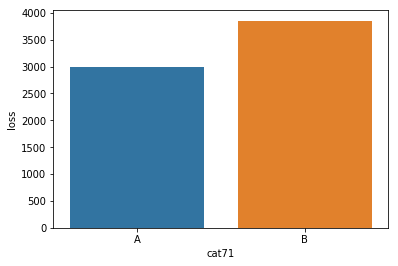

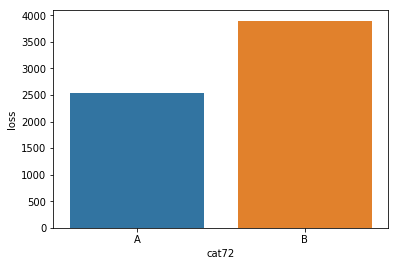

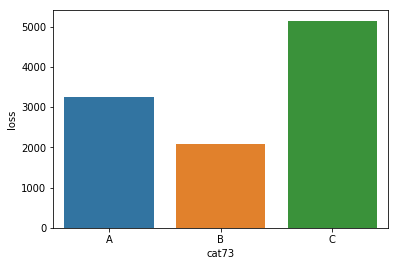

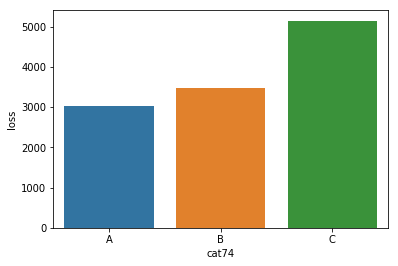

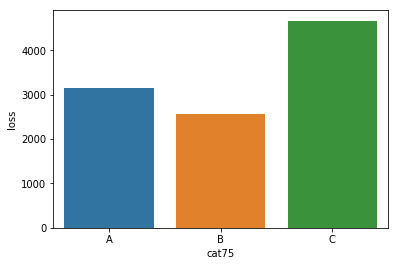

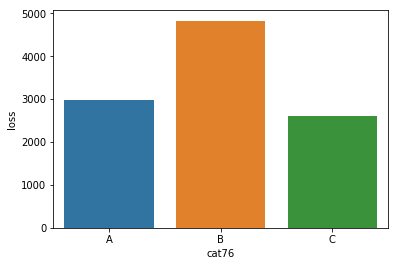

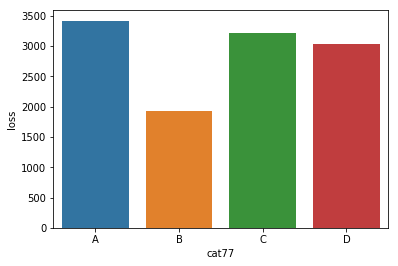

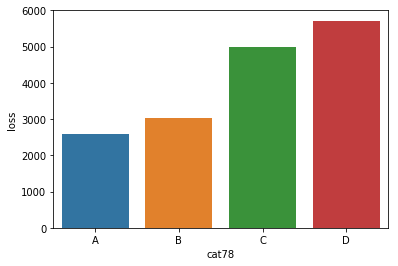

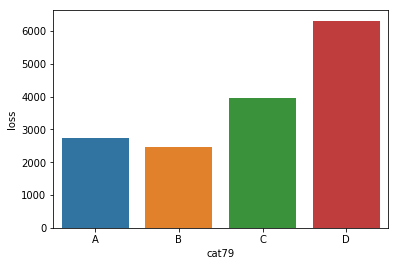

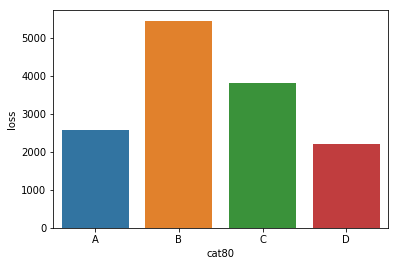

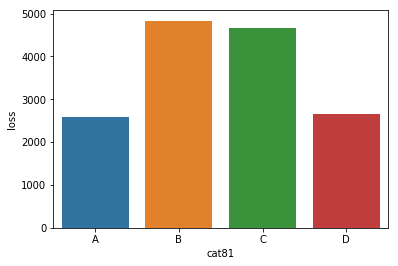

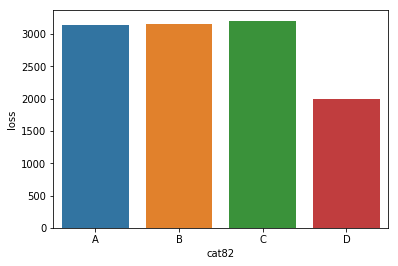

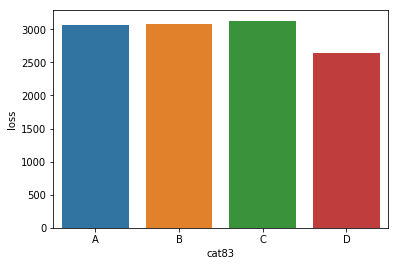

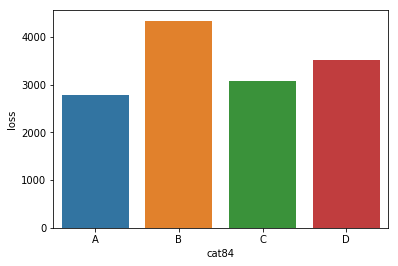

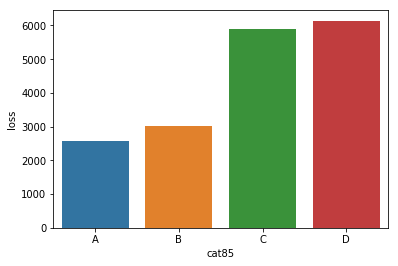

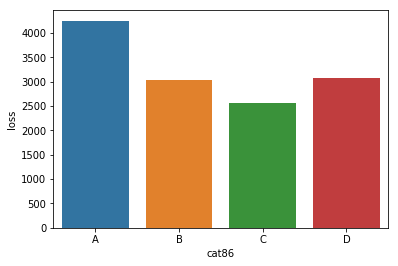

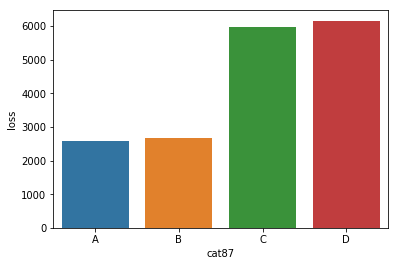

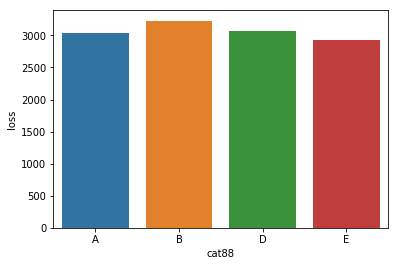

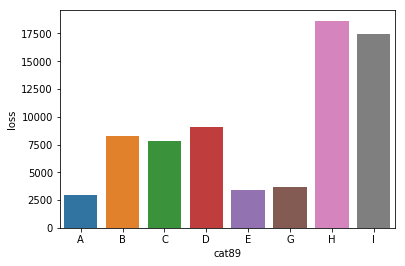

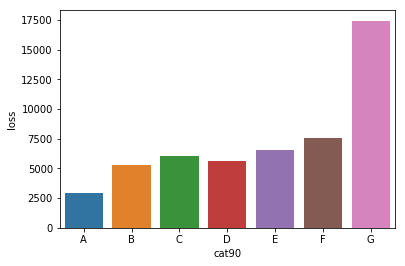

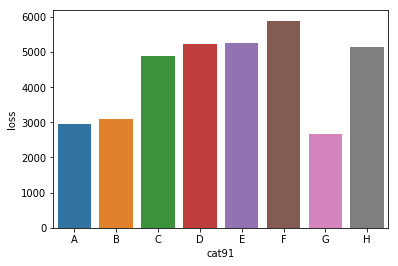

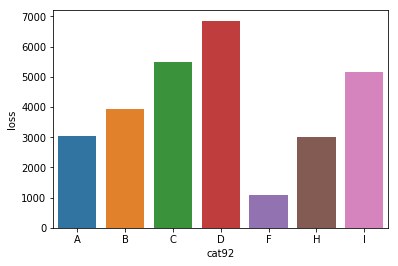

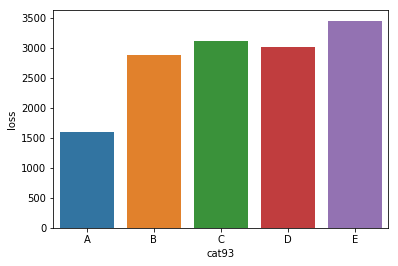

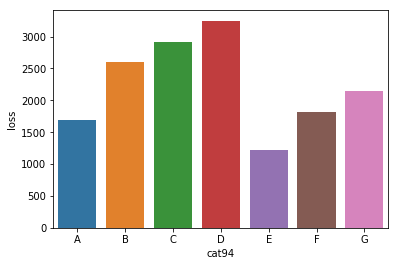

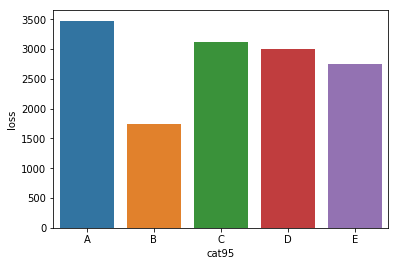

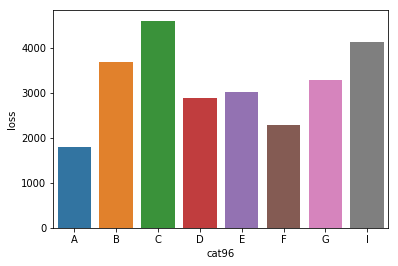

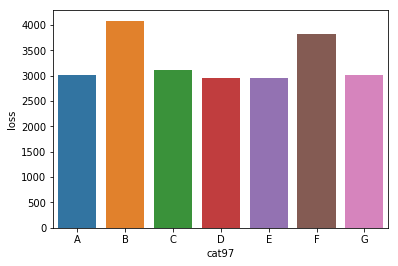

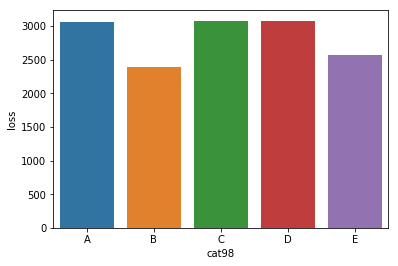

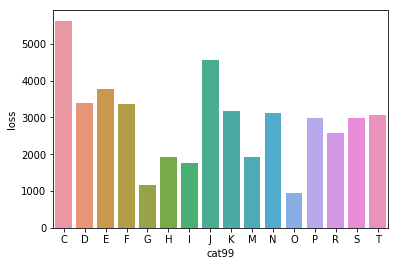

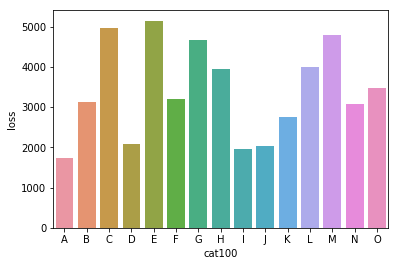

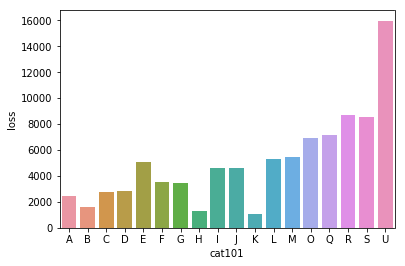

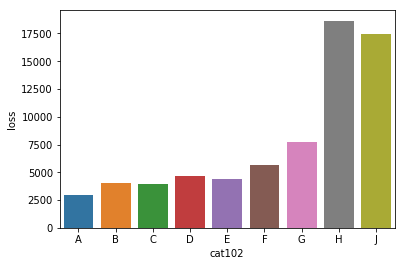

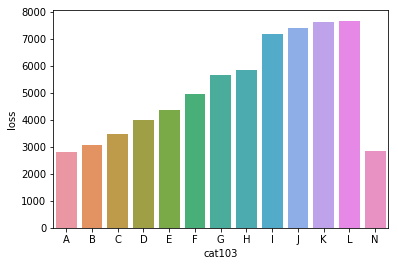

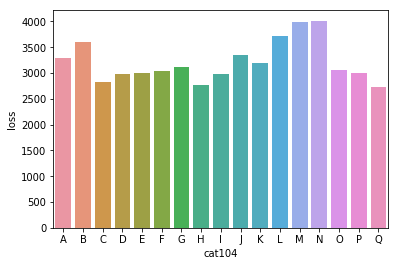

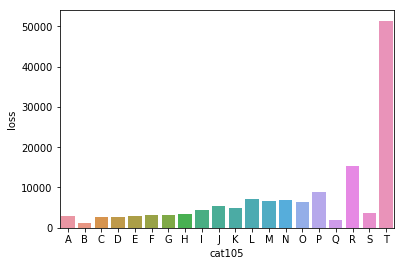

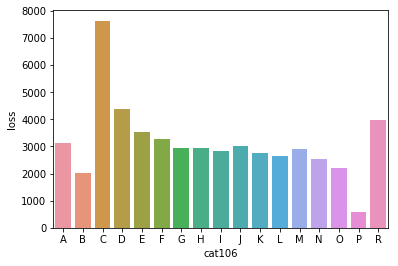

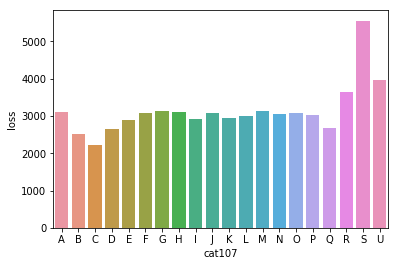

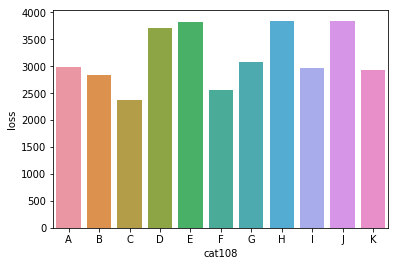

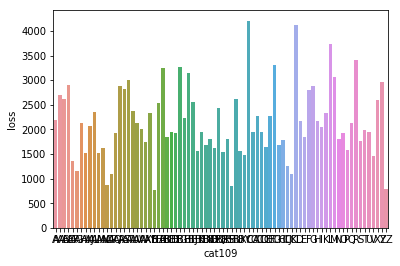

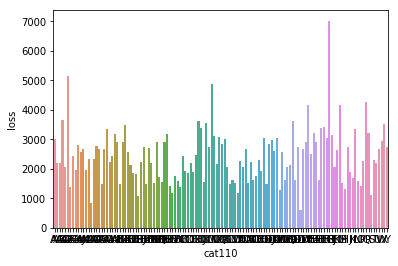

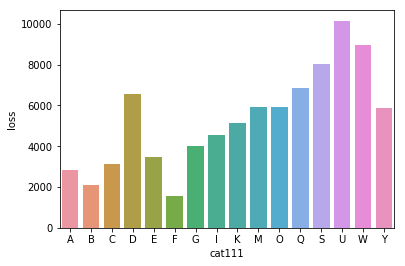

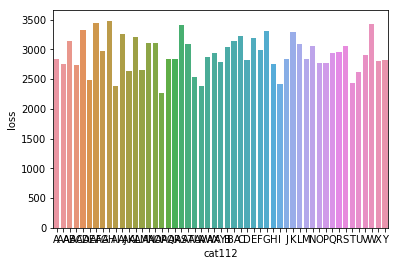

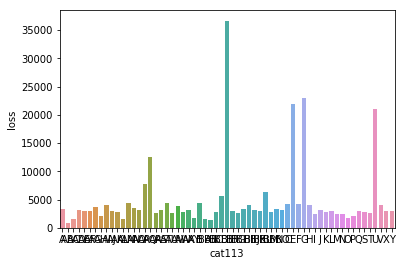

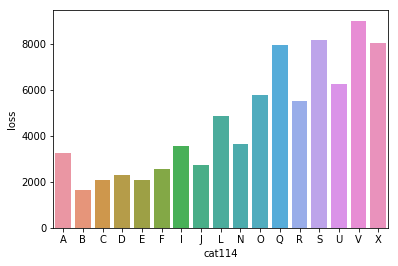

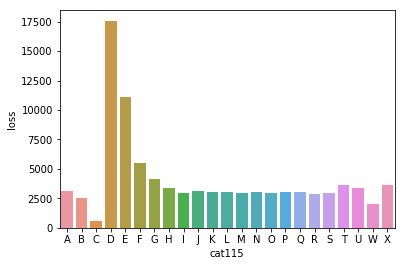

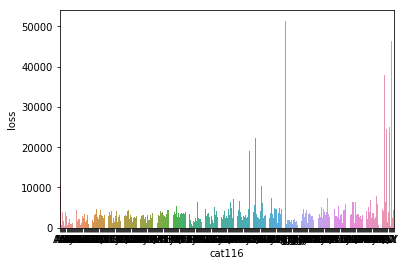

DataError: No numeric types to aggregate

In [29]:
for i in df_train_cat.columns :
    sns.barplot(x=i,y='loss',data=df_train_cat.groupby([i],as_index=False).mean())
    plt.show()

In [ ]:
df_train_cont=df_train.iloc[:,116:131]

In [44]:
df_train_cont.corr()

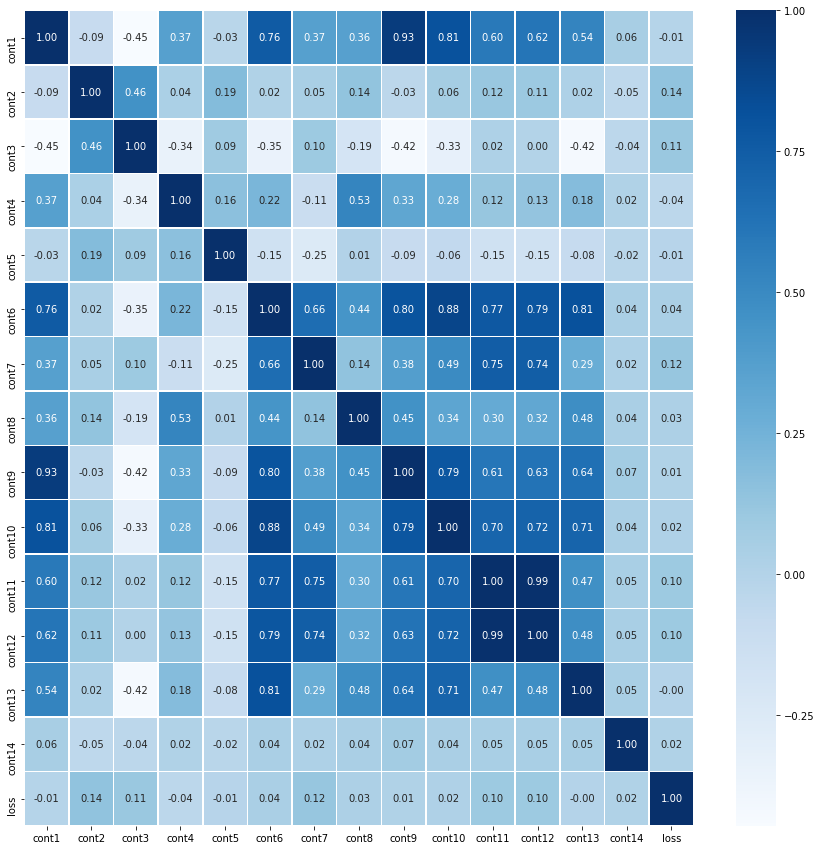

In [43]:
plt.figure(figsize=(15,15))
sns.heatmap(data = df_train_cont.corr(), annot=True, fmt= '.2f', linewidths =.5, cmap='Blues')

In [72]:
a='cont1+cont2+cont3+cont4+cont5+cont6+cont7+cont8+cont9+cont10+cont11+cont12+cont13+cont14'
y, X = dmatrices("loss~"  +a,data = df_train_cont, return_type = 'dataframe')

In [84]:
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
result = sm.OLS(y,X).fit()

In [86]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   loss   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     392.8
Date:                Tue, 09 Apr 2019   Prob (F-statistic):               0.00
Time:                        19:38:48   Log-Likelihood:            -1.2349e+06
No. Observations:              131822   AIC:                         2.470e+06
Df Residuals:                  131807   BIC:                         2.470e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1507.1469     59.297     25.417      0.0

In [87]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [88]:
vif.round(2)

,VIF Factor,features
0,57.74,Intercept
1,12.54,cont1
2,1.54,cont2
3,2.60,cont3
4,2.01,cont4
5,1.20,cont5
6,22.17,cont6
7,4.69,cont7
8,2.11,cont8
9,10.87,cont9


(56496, 131)